In [1]:
#!/usr/bin/python
#dbr 01/22/25
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import matplotlib.cm as cm

import seaborn as sns
sns.set_style("ticks")


In [2]:
#additional 4 cytokines
cyto4_df = pd.read_csv('data/cytokines4plex.csv')

cyto4_df = cyto4_df[cyto4_df['Experiment']=='OPH_Uplex'].dropna() #just OPH

#add short ids
sid=[]
for i in range(len(cyto4_df['seattle_masterptid'])):
    pid=cyto4_df['seattle_masterptid'].iloc[i]
    sid.append(float(str(pid)[4:7]))

cyto4_df['id']=sid

cyto4_df = cyto4_df[['id','MSD_month_code','level_GranzymeB','level_IL15', 'level_IL7','level_IL2']]

#rename columns
cyts0 = ['level_GranzymeB', 'level_IL15', 'level_IL7','level_IL2']

for c in cyts0:
    cyto4_df = cyto4_df.rename(columns={c:c.split('_')[1]}) 

cyto4_df = cyto4_df.rename(columns={'GranzymeB':'GzB','MSD_month_code':'ARTmo'})
    
cyto4_df.sort_values(by='ARTmo',inplace=True)



In [3]:
#define data and color

cs=['GzB','IL2', 'IL7','IL15']
cz = ['#FF5733','#FF3333','#0066CC','#3399FF']


In [4]:
#switch to log-scale for gzb? or all??
for c in cs:
    cyto4_df[c]=np.log10(cyto4_df[c])
    
cyto4_df.head()

,id,ARTmo,GzB,IL15,IL7,IL2
0,100.0,0.0,1.717811,0.938630,1.095159,1.333197
233,128.0,0.0,1.671425,0.521897,1.388235,1.411511
234,118.0,0.0,1.929807,0.596957,1.470746,1.424051
235,101.0,0.0,2.131834,1.363905,1.380242,2.091171
238,124.0,0.0,1.727066,0.158746,0.784146,0.892560


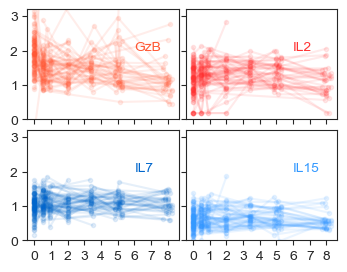

In [5]:
#plot cytokine levels, fixed...

fig,axs = plt.subplots(2,2,figsize=(4,3),sharex=True,sharey=True)
for i,c in enumerate(cs):
    ax=axs[int(i/2)][i%2]
    
    for p in cyto4_df['id'].unique():        
        
        meanval = np.mean(cyto4_df[c])
        stdval = np.std(cyto4_df[c])
        
        tdf = cyto4_df[cyto4_df['id']==p]
        #ax.plot(tdf['ARTmo']/12,tdf[c]-tdf[c].iloc[0],color=cz[i],alpha=0.1,marker='.')
        ax.plot(tdf['ARTmo']/12,tdf[c],color=cz[i],alpha=0.1,marker='.')
        #ax.plot(tdf['ARTmo']/12,(tdf[c]-meanval)/stdval,color=cz[i],alpha=0.1,marker='.')
    
    ax.annotate(c,[6,2],color=cz[i])
    
ax.set_xticks(range(0,9,))
ax.set_yticks(range(0,4))
ax.set_ylim(0,3.2)
        
fig.subplots_adjust(hspace=0.1,wspace=0.05)
fig.savefig('figures/cytokines.svg',dpi=600)


In [6]:
#collect values at baseline and setpoint

#get baseline
baseline_levels = cyto4_df[cyto4_df['ARTmo']==0]

#get median after 1 year
setpoint = cyto4_df[cyto4_df['ARTmo']>0].groupby('id').mean()

setpoint = setpoint.reset_index()

In [7]:
#cluster cytokines together

# function to make heatmaps with Compute correlations and p-values
def corr_with_pvalues(df,ctype):
    cols = df.columns
    corr_matrix = pd.DataFrame(index=cols, columns=cols)
    p_matrix = pd.DataFrame(index=cols, columns=cols)
    
    for i in cols:
        for j in cols:
            if i == j:
                corr_matrix.loc[i, j] = 1.0
                p_matrix.loc[i, j] = 0.0
            else:
                if ctype=='Pearson':
                    corr, p = st.pearsonr(df[i], df[j])
                if ctype=='Spearman':
                    corr, p = st.spearmanr(df[i], df[j])
                corr_matrix.loc[i, j] = corr
                p_matrix.loc[i, j] = p
    
    return corr_matrix.astype(float), p_matrix.astype(float)



/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_97123/2843180569.py:20: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


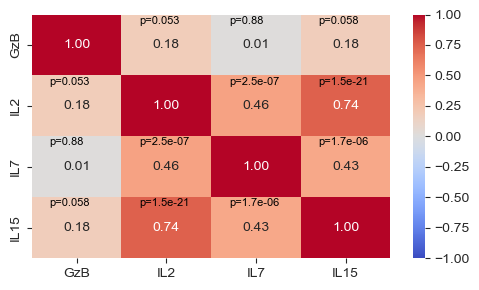

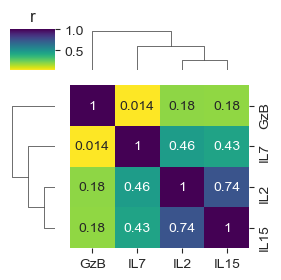

In [8]:
#baseline correlations, use function above

corr_matrix, p_matrix = corr_with_pvalues(baseline_levels[cs],'Spearman')

# Plot the heatmap with annotations
plt.figure(figsize=(5,3))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,vmin=-1,vmax=1)

# Add p-values as text annotations
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        if i != j:  # Exclude diagonal
            plt.text(j + 0.2, i + 0.1, f"p={p_matrix.iloc[i, j]:.2g}",
                     ha='left', va='center', color="black", fontsize=8)
plt.tight_layout()
plt.savefig('figures/cytokines-selfcorr-baseline1.pdf',dpi=600)

sns.clustermap(baseline_levels[cs].corr(method='spearman'),figsize=(3,3),cmap='viridis_r',annot=True)
plt.title('r')
plt.tight_layout()
plt.savefig('figures/cytokines-selfcorr-baseline2.pdf',dpi=600)



/var/folders/yk/0drxrmsj07l2thjtfhfyxcxh0000gn/T/ipykernel_97123/3034670410.py:21: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


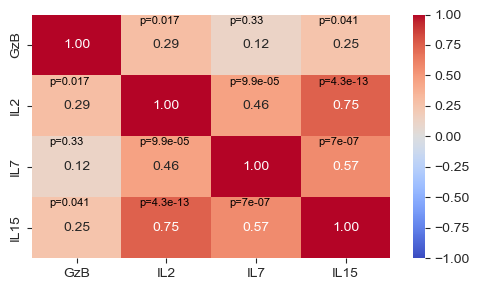

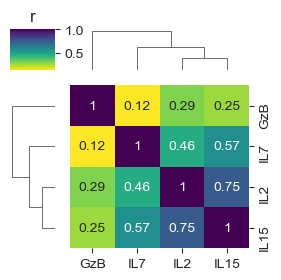

In [9]:
#setpoint correlations, use function above

corr_matrix, p_matrix = corr_with_pvalues(setpoint[cs],'Spearman')

# Plot the heatmap with annotations
plt.figure(figsize=(5,3))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,vmin=-1,vmax=1)

# Add p-values as text annotations
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[1]):
        if i != j:  # Exclude diagonal
            plt.text(j + 0.2, i + 0.1, f"p={p_matrix.iloc[i, j]:.2g}",
                     ha='left', va='center', color="black", fontsize=8)
plt.tight_layout()
plt.savefig('figures/cytokines-selfcorr-setpoint1.pdf',dpi=600)


sns.clustermap(setpoint[cs].corr(method='spearman'),figsize=(3,3),cmap='viridis_r',annot=True)
plt.title('r')
plt.tight_layout()
plt.savefig('figures/cytokines-selfcorr-setpoint2.pdf',dpi=600)


In [10]:
#the IPDA cell virus decay rates for monolix
HIV_rate_df = pd.read_csv('data/rates_monolix_indiv.csv')

ds1 = ['RNA<1(1)','RNA<1(2)','Intact<1','Defective<1','CD4<1']
ds2 = ['Intact>1','Defective>1','CD4>1']

#switch all signs!
for c in ds1+ds2:
    HIV_rate_df[c]=np.abs(HIV_rate_df[c])

No p-values are significant.


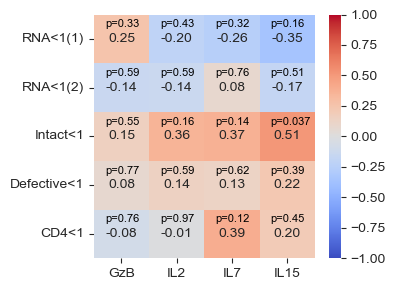

In [11]:
#correlations between <1 decay and baseline cytokines

adf = pd.merge(baseline_levels,HIV_rate_df,on='id',how='inner').dropna() #merged for rates
adf.drop(columns=['Unnamed: 0','id','ARTmo'],inplace=True)

corr_matrix, p_matrix = corr_with_pvalues(adf,'Pearson')

corr_matrix2 = corr_matrix.loc[ds1,cs]
p_matrix2 = p_matrix.loc[ds1,cs]

# Plot the heatmap with annotations
plt.figure(figsize=(4,3))
sns.heatmap(corr_matrix2, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,vmin=-1,vmax=1)

# Add p-values as text annotations
for i in range(corr_matrix2.shape[0]):
    for j in range(corr_matrix2.shape[1]):
        plt.text(j + 0.2, i + 0.2, f"p={p_matrix2.iloc[i, j]:.2g}",
                     ha='left', va='center', color="black", fontsize=8)
plt.tight_layout()
plt.savefig('figures/cytokines-setpoint-corr.pdf',dpi=600)

#Steps for the Benjamini-Hochberg Procedure

alpha = 0.05  # Desired FDR

pz = p_matrix2.to_numpy().flatten()

# Step 1: Sort p-values and get their indices
sorted_indices = np.argsort(pz)
sorted_p_values = pz[sorted_indices]

# Step 2: Calculate BH thresholds
m = len(pz)
thresholds = (np.arange(1, m + 1) / m) * alpha

# Step 3: Find the largest significant p-value
significant = sorted_p_values <= thresholds
if significant.any():
    max_significant_idx = np.where(significant)[0][-1]
    threshold_p_value = sorted_p_values[max_significant_idx]
    print(f"Threshold p-value: {threshold_p_value}")
else:
    print("No p-values are significant.")



No p-values are significant.


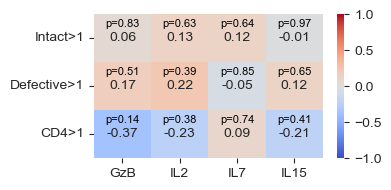

In [12]:
#correlations between >1 decay and setpoint cytokines

adf2 = pd.merge(setpoint,HIV_rate_df,on='id',how='inner').dropna() #merged for rates
adf2.drop(columns=['Unnamed: 0','id','ARTmo'],inplace=True)

corr_matrix, p_matrix = corr_with_pvalues(adf2,'Pearson')

corr_matrix2 = corr_matrix.loc[ds2,cs]
p_matrix2 = p_matrix.loc[ds2,cs]

# Plot the heatmap with annotations
plt.figure(figsize=(4,2))
sns.heatmap(corr_matrix2, annot=True, fmt=".2f", cmap='coolwarm', cbar=True,vmin=-1,vmax=1)

# Add p-values as text annotations
for i in range(corr_matrix2.shape[0]):
    for j in range(corr_matrix2.shape[1]):
        plt.text(j + 0.2, i + 0.2, f"p={p_matrix2.iloc[i, j]:.2g}",
                     ha='left', va='center', color="black", fontsize=8)
plt.tight_layout()
plt.savefig('figures/cytokinesvsdecay-base-corr.pdf',dpi=600)

#Steps for the Benjamini-Hochberg Procedure

alpha = 0.05  # Desired FDR

pz = p_matrix2.to_numpy().flatten()

# Step 1: Sort p-values and get their indices
sorted_indices = np.argsort(pz)
sorted_p_values = pz[sorted_indices]

# Step 2: Calculate BH thresholds
m = len(pz)
thresholds = (np.arange(1, m + 1) / m) * alpha

# Step 3: Find the largest significant p-value
significant = sorted_p_values <= thresholds
if significant.any():
    max_significant_idx = np.where(significant)[0][-1]
    threshold_p_value = sorted_p_values[max_significant_idx]
    print(f"Threshold p-value: {threshold_p_value}")
else:
    print("No p-values are significant.")



/Users/dreeves/anaconda3/lib/python3.11/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


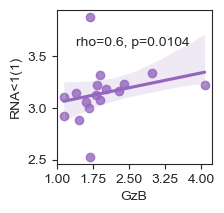

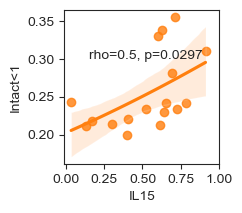

In [13]:
#show some interesting/significant ones
#use data type colors (vs cytokine colors?)

plt.figure(figsize=(2,2))
ax=plt.gca()
sns.regplot(adf['GzB'],adf['RNA<1(1)'],color='tab:purple')
r,p=st.spearmanr(adf['GzB'],adf['RNA<1(1)'])
plt.annotate('rho='+str(np.round(r,1))+', p='+str(np.round(p,4)),[1.4,3.6])
plt.xticks(np.linspace(1,4,5))
plt.savefig('figures/cytokines-corrGzBRNA1.svg',dpi=600)

plt.figure(figsize=(2,2))
sns.regplot(adf['IL15'],adf['Intact<1'],color='tab:orange',logistic=True,label='off')
r,p=st.spearmanr(adf['IL15'],adf['Intact<1'])
plt.annotate('rho='+str(np.round(r,1))+', p='+str(np.round(p,4)),[0.15,0.3])
plt.xticks(np.linspace(0,1,5))
plt.savefig('figures/cytokines-corrIL15intact.svg',dpi=600)


In [14]:
#loop through and print pvalues??
measurenm=['baseline','setpoint']
for i,tdf in enumerate([adf,adf2]):
    print(measurenm[i])
    for c in cs:
        for d in [ds1,ds2][i]:
            rho, pval = st.spearmanr(tdf[c], tdf[d])
            if pval<0.05:
                print(c,d,rho,pval)
                

baseline
GzB RNA<1(1) 0.6029411764705883 0.010406870395559813
IL15 Intact<1 0.5269607843137256 0.02974441940918236
setpoint
